# Obtaining the residuals with the maximum-likelihood waveform subtracted

**Alex B. Nielsen<sup>1,2</sup>, Alexander H. Nitz<sup>1,2</sup>, Collin Capano<sup>1,2</sup>, and Duncan A. Brown<sup>3</sup>**

 <sub>1. [Albert-Einstein-Institut, Max-Planck-Institut for Gravitationsphysik, D-30167 Hannover, Germany](http://www.aei.mpg.de/obs-rel-cos)</sub>  
 <sub>2. Leibniz Universitat Hannover, D-30167 Hannover, Germany</sub>  
 <sub>3. Department of Physics, Syracuse University, Syracuse, NY 13244, USA</sub>  

![Creative Commons License](https://i.creativecommons.org/l/by-sa/3.0/us/88x31.png "Creative Commons License")

This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 United States License](http://creativecommons.org/licenses/by-sa/3.0/us/).

We encourage use of these data in derivative works. If you use the material provided here, please cite [our paper.]()

To obtain residuals, we need to generate the best-fitting GR waveform and subtract it from the data. To obtain the best-fit waveform we use the parameters found in [Biwer et al.](https://arxiv.org/abs/1807.10312); the samples from that analysis are available for [download from github/gwastro](https://github.com/gwastro/pycbc-inference-paper). By "best fit," we mean the waveform that maximizes the likelihood (the "maximum-likelihood waveform"),

\begin{equation}
 p(d|\vec{\Theta}, h) = \exp\left[-\frac{1}{2} \sum_{i=1}^{N_d} \left<d_i - h_i(\vec{\Theta}),\, d_i-h_i(\vec{\Theta})\right> \right].
\end{equation}

Here, $d$ is the detector data, $h$ is the waveform model, $\vec{\Theta}$ is the set of parameters describing the signal (the component masses, spins, etc.), and the sum is over the number of detectors $N_d$ (which in this case is 2: Hanford and Livingston). The parameters $\vec{\Theta}$ that maximize the likelihood (the "maxL parameters") are obtained by stochastically sampling the parameter space.

The gravitational waveform may be shifted by a constant phase shift $\phi_0$ independent of the intrinsic parameters of the binary. The maxL parameters we obtain from the [downloaded data](https://github.com/gwastro/pycbc-inference-paper) do not contain this phase shift because $\phi_0$ was analytically marginalized over in Biwer et al. As a result, we must find the maxL phase shift here.

In this notebook we:

1. download the detector data containing GW150914 from the [GW Open Science Center](https://www.gw-openscience.org); 
1. download the samples from Biwer et al. and extract the maximum-likelihood parameters;
1. generate the waveform, find the maxL $\phi_0$, and shift the waveforms;
1. subtract the maxL waveforms from the data to obtain the residuals.

The notebook produces an hdf file, `residuals.hdf`, which contains the residual time series, along with the maximum-likelihood waveforms in each detector. As a last step, we load the residuals back in from the file, and plot them, along with the data and maximum-likelihood waveform.

In [1]:
%matplotlib notebook
from matplotlib import pyplot
import h5py
import numpy
import os
from pycbc.types import TimeSeries
from pycbc.io.inference_hdf import InferenceFile
from pycbc.waveform.generator import FDomainCBCGenerator, FDomainDetFrameGenerator
from pycbc import psd as pypsd
from pycbc import filter
from pycbc import frame
from pycbc import waveform

## Get the data around GW150914

In [2]:
# data settings
# times from run script in pycbc inference paper repo
psd_start_time = 1126258940
psd_end_time = 1126259980
data_start_time = 1126259452
data_end_time = 1126259468
pad_data = 8 # for the high pass filter
fhighpass = 15
psd_seg_len = 16
psd_seg_stride = 8
inverse_psd_len = 4
sample_rate = 4096 # we'll just use the same as the LOSC data
seg_len = data_end_time - data_start_time
filter_fmin = 20.
print "segment length:", seg_len

segment length: 16


In [3]:
data_files = {'H1': 'H-H1_LOSC_4_V2-1126257414-4096.gwf',
              'L1': 'L-L1_LOSC_4_V2-1126257414-4096.gwf'}

Download the data if it is not already available in the current working directory.

In [4]:
if not os.path.exists('H-H1_LOSC_4_V2-1126257414-4096.gwf'):
    !wget https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.gwf
if not os.path.exists('L-L1_LOSC_4_V2-1126257414-4096.gwf'):
    !wget https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.gwf

--2018-11-11 21:08:12--  https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.125.179
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.125.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130066842 (124M)
Saving to: ‘H-H1_LOSC_4_V2-1126257414-4096.gwf’

H-H1_LOSC_4_V2-1126 100%[===================>] 124.04M  3.98MB/s    in 60s     

2018-11-11 21:09:12 (2.08 MB/s) - ‘H-H1_LOSC_4_V2-1126257414-4096.gwf’ saved [130066842/130066842]

--2018-11-11 21:09:12--  https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.125.179
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.125.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125705186 (120M)
Saving to: ‘L-L1_LOSC_4_V2-1126257414-4096.gwf’

L-L1_LOSC_4_V2-1126 1

Read data from the frames into memory to make a power spectral density that will be used to find the correct waveform phase. Pad the data since we will filter the data and we do not want the data used in the analysis to be corrupted by filter startup transients.

In [5]:
psd_data = {}
for ifo, fn in data_files.items():
    psd_data[ifo] = frame.read_frame(fn, '{}:LOSC-STRAIN'.format(ifo), start_time=psd_start_time-pad_data,
                                     end_time=psd_end_time+pad_data)

Highpass the data and discard the padding, and then create a slice of data around the GW150914 event for the analysis.

In [6]:
for ifo,d in psd_data.items():
    d = filter.highpass(d, fhighpass)
    psd_data[ifo] = d.time_slice(psd_start_time, psd_end_time)

Load the full strain data for analysis.

In [7]:
data = {}
for ifo, fn in data_files.items():
    data[ifo] = frame.read_frame(fn, '{}:LOSC-STRAIN'.format(ifo))

## Get the GW150914 posterior samples from Biwer et al.

To generate a waveform with parameters that match GW150914, we use the posterior parameter estimation samples from [Biwer et al.](https://arxiv.org/abs/1807.10312). The [supplemental materials](https://github.com/gwastro/pycbc-inference-paper) released by Biwer et al. include the posterior samples from the analysis of GW150914 as a HDF5 file.

In [8]:
if not os.path.exists('gw150914_posteriors_thinned.hdf'):
    !wget https://github.com/gwastro/pycbc-inference-paper/raw/master/posteriors/GW150914/gw150914_posteriors_thinned.hdf

--2018-11-11 21:11:09--  https://github.com/gwastro/pycbc-inference-paper/raw/master/posteriors/GW150914/gw150914_posteriors_thinned.hdf
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwastro/pycbc-inference-paper/master/posteriors/GW150914/gw150914_posteriors_thinned.hdf [following]
--2018-11-11 21:11:10--  https://raw.githubusercontent.com/gwastro/pycbc-inference-paper/master/posteriors/GW150914/gw150914_posteriors_thinned.hdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5076144 (4.8M) [application/octet-stream]
Saving to: ‘gw150914_posteriors_thinned.hdf’

gw150914_posterio

In [9]:
fp = InferenceFile('gw150914_posteriors_thinned.hdf', 'r')

First we read the posteriors file to determine which parameters were measured by Biwer et al.

In [10]:
variable_args = fp.attrs['variable_args']

Next, we obtain the fixed parameters from the analysis of Biwer et al. These are the waveform approximant name and the lower frequency cutoff. This are obtained from the [configuration file](https://github.com/gwastro/pycbc-inference-paper/blob/master/run_files/GW150914/gw150914_inference.ini) in the Biwer et al. supplemental materials.

The low-frequency cutoff `f_lower` used by Biwer et al. is 20 Hz. To get a get good subtraction of the residuals at 20Hz, here we generate the waveform starting the waveform at a lower frequency by setting `f_lower` to 10 Hz. We set `f_ref` to 20 Hz so that the waveform is determined by the parameters measured at 20 Hz by Biwer et al.

In [11]:
static_args = {'approximant': 'IMRPhenomPv2',
               'f_lower': 10.0,
               'f_ref': 20.0}

Read in the posterior samples

In [12]:
samples = fp.read_samples(variable_args)

Now we find the parameters of the waveform with the maximum likelihood value from the posterior samples. We select this as the best matching waveform to the GW150914 signal.

In [13]:
posterior_stats = fp.read_likelihood_stats()
maxLpt = posterior_stats['loglr'].argmax()
maxLR = posterior_stats['loglr'][maxLpt]
print("MaxL point, SNR: {}, {}".format(maxLpt, (2*maxLR)**0.5))
maxL_params = samples[maxLpt]
print("MaxL parameters:\n{}".format('\n'.join(sorted(['{}: {}'.format(p, maxL_params[p])
                                                     for p in samples.fieldnames]))))
tc = maxL_params['tc']

MaxL point, SNR: 8404, 24.2247326805
MaxL parameters:
coa_phase: 0.688321253938
dec: -1.27348105486
distance: 476.756454722
inclination: 2.91327137822
mass1: 39.0257656982
mass2: 32.0625631219
polarization: 5.99252318066
ra: 1.57302574592
spin1_a: 0.976796166199
spin1_azimuthal: 3.60369523082
spin1_polar: 1.62835485076
spin2_a: 0.188760881592
spin2_azimuthal: 3.43594606233
spin2_polar: 2.49152689797
tc: 1126259462.42


## Generate the maximum likelihood waveform

Here we generate the gravitational wave strain h(t) for the maximum likelihood waveform parameters.

### Measure the correct waveform phase

In the Biwer at al. analysis, the wavefom phase was marginzliaed analytically. This means to reconstruct the maxL waveform, we need to figure out the correct phase offset to use for the waveform. To do this, we match filter the maxL waveform against the data. This requires estimating a power spectral density.

#### Estimate and plot power spectral density

In [14]:
psds = {}
for ifo, d in psd_data.items():
    psd = pypsd.welch(d, seg_len=psd_seg_len*sample_rate, seg_stride=psd_seg_stride*sample_rate)
    # truncate
    psd = pypsd.inverse_spectrum_truncation(psd, inverse_psd_len*sample_rate, low_frequency_cutoff=15.)
    # interpolate to needed df
    psd = pypsd.interpolate(psd, data['H1'].delta_f)
    psds[ifo] = psd

<IPython.core.display.Javascript object>


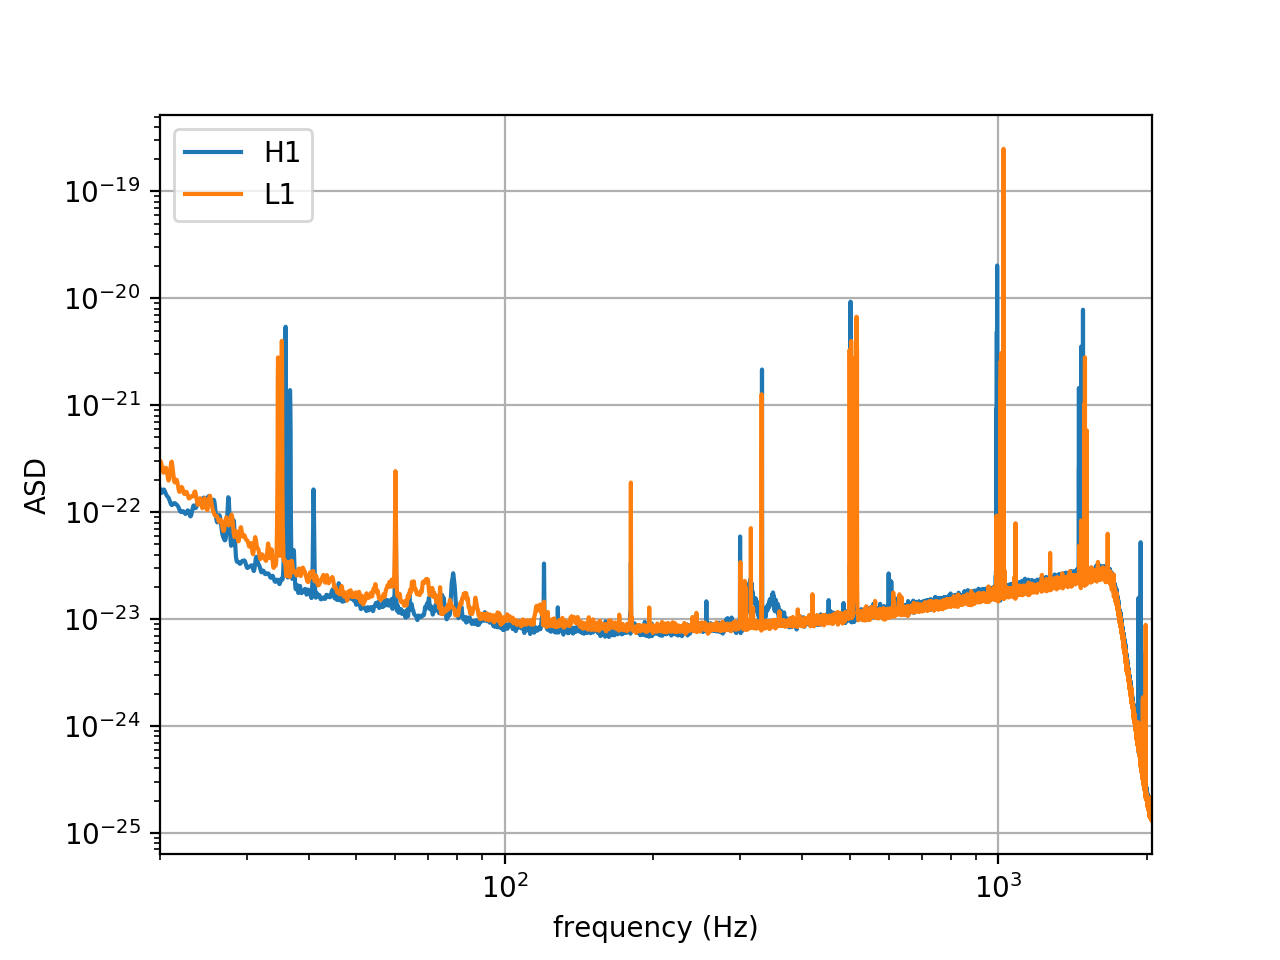

In [15]:
fig, ax = pyplot.subplots()
ax.loglog()
for ifo,psd in psds.items():
    ax.plot(psd.sample_frequencies, psd**0.5, label=ifo)
ax.legend()
ax.grid()
ax.set_xlim(20, 2048)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('ASD')
fig.show()

Note that the PSD tapers off signficantly between 1000 and 2000 Hz. This is due to the resampling that was applied to the data downloaded from GWOSC. For this reason, we'll stop our matched filter at 1024 Hz, to prevent corruption in our estimate.

In [16]:
filter_fmax = 1024.

#### Find the maximum phase

To generate the waveform we'll create a generator class. This generates a waveform in the frequency domain for a given set of parameter values, and applies the detector response functions. This is the same class that is used by the parameter estimation code that generated the posterior samples, so we can be sure that the returned waveform is exactly the same as what was used in the code.

In [17]:
generator = FDomainDetFrameGenerator(FDomainCBCGenerator, data['H1'].start_time, detectors=data.keys(),
                                     variable_args=variable_args, delta_f=data['H1'].delta_f, **static_args)

Generate the waveform strain. This function returns a dictionary of FrequencySeries, keyed by the detector name.

In [18]:
htildes = generator.generate(**{p: maxL_params[p] for p in variable_args})

Now compute the phase offset needed to match the GW150914 signal in the data.

In [19]:
cplx_hd = 0j
hh = 0.
for ifo,d in data.items():
    htilde = htildes[ifo]
    dtilde = d.to_frequencyseries()
    htilde.resize(len(dtilde))
    cplx_hd += filter.overlap_cplx(htilde, dtilde, psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                                   high_frequency_cutoff=filter_fmax,
                                   normalized=False)
    hh += filter.sigmasq(htilde, psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                         high_frequency_cutoff=filter_fmax)

Unwrap the complex overlap time series returned and save the measured phase offset in `phase_shift`.

In [20]:
phase_shift = numpy.angle(cplx_hd)
print("Phase shift: {0:.9f}".format(phase_shift))

Phase shift: -0.915527673


Now apply the phase offset to the frequency-domain waveform to correctly match the GW150914 phase.

In [21]:
for ifo, h in htildes.items():
    htildes[ifo] = h * numpy.exp(1j * phase_shift)

Finally, check that if we repeat this analysis with the shifted waveform, we should get a zero phase offset. We'll also check the signal-to-noise ratio (SNR). Based on the GW150914 publications, we expect this to be ~24.

In [22]:
cplx_hd = 0j
hh = 0.
for ifo in data:
    htilde = htildes[ifo]
    dtilde = data[ifo].to_frequencyseries()
    htilde.resize(len(dtilde))
    cplx_hd += filter.overlap_cplx(htilde, dtilde, psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                                   high_frequency_cutoff=filter_fmax,
                                   normalized=False)
    hh += filter.sigmasq(htilde, psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                         high_frequency_cutoff=filter_fmax)
check_phase_shift = numpy.angle(cplx_hd)
print("Phase shift: {0:.9f}".format(check_phase_shift))
cplx_loglr = cplx_hd - 0.5*hh
print("SNR: {0:.9f}".format((2*cplx_loglr.real)**0.5))

Phase shift: -0.000000000
SNR: 24.361690225


This test passes if the reported phase offset is `0.0`.

## Subtract the maximum likelihood waveform from the data

The IMRPhenompPv2 waveform is generated in the frequency domain, so to subtract it from the gravitational-wave strain we must inverse Fourier transform it to the time domain. We apply a tapering window in the frequency domain between 10 and 15Hz so that we do not get Gibbs junk in the time-domain waveform.

In [23]:
waveforms = {}
for ifo, htilde in htildes.items():
    h = waveform.fd_to_td(htilde, delta_t=data['H1'].delta_t, left_window=(10.,15.))
    waveforms[ifo] = h

**Check:** We should get the same SNR as above (24.36) if we filter the tapered waveform with the data.

In [24]:
cplx_hd = 0j
hh = 0.
for ifo in data:
    dtilde = data[ifo].to_frequencyseries()
    htilde = waveforms[ifo].to_frequencyseries()
    cplx_hd += filter.overlap_cplx(htilde, dtilde, psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                                  high_frequency_cutoff=filter_fmax,
                                  normalized=False)
    hh += filter.sigmasq(htildes[ifo], psd=psds[ifo], low_frequency_cutoff=filter_fmin,
                        high_frequency_cutoff=filter_fmax)
    
check_phase_shift = numpy.angle(cplx_hd)
print("Phase shift: {0:.9f}".format(check_phase_shift))
cplx_loglr = cplx_hd - 0.5*hh
print("SNR: {0:.9f}".format((2*cplx_loglr.real)**0.5))

Phase shift: -0.000000000
SNR: 24.361690225


Now we calculate the residuals and save the result. We save to a new HDF5 file along with the maximum likelihood waveform and the maximum likelihood waveform's parameters.

In [25]:
residuals = {ifo: data[ifo]-waveforms[ifo] for ifo in data}

In [26]:
out = h5py.File('residuals.hdf', 'w')
for (ifo, d) in residuals.items():
    out.create_group(ifo)
    dset = '{}/residual'.format(ifo)
    out.create_dataset(dset, data=d.numpy(), compression='gzip')
    out[dset].attrs['delta_t'] = d.delta_t
    out[dset].attrs['start_time'] = float(d.start_time)
    h = waveforms[ifo]
    dset = '{}/maxl_waveform'.format(ifo)
    out.create_dataset(dset, data=h.numpy(), compression='gzip')
    out[dset].attrs['delta_t'] = h.delta_t
    out[dset].attrs['start_time'] = float(h.start_time)

for p in variable_args:
    out.attrs[p] = maxL_params[p]

for p in static_args:
    out.attrs[p] = static_args[p]

out.attrs['phase_shift'] = phase_shift

out.close()

## Plot the data saved to the file

We read the residual data and waveforms back in from the HDF5 file and plot them here.

In [27]:
fp = h5py.File('residuals.hdf', 'r')
residuals_from_file = {}
waveforms_from_file = {}
for ifo in fp:
    dset = '{}/residual'.format(ifo)
    residuals_from_file[ifo] = TimeSeries(fp[dset][:], delta_t=fp[dset].attrs['delta_t'],
                                          epoch=fp[dset].attrs['start_time'])
    dset = '{}/maxl_waveform'.format(ifo)
    waveforms_from_file[ifo] = TimeSeries(fp[dset][:], delta_t=fp[dset].attrs['delta_t'],
                                          epoch=fp[dset].attrs['start_time'])
fp.close()

In the plots, we show a small window around the merger

In [28]:
tstart = tc - 0.1
tend = tc + 0.05

### Unwhitened maxiumum likelihood waveform

<IPython.core.display.Javascript object>


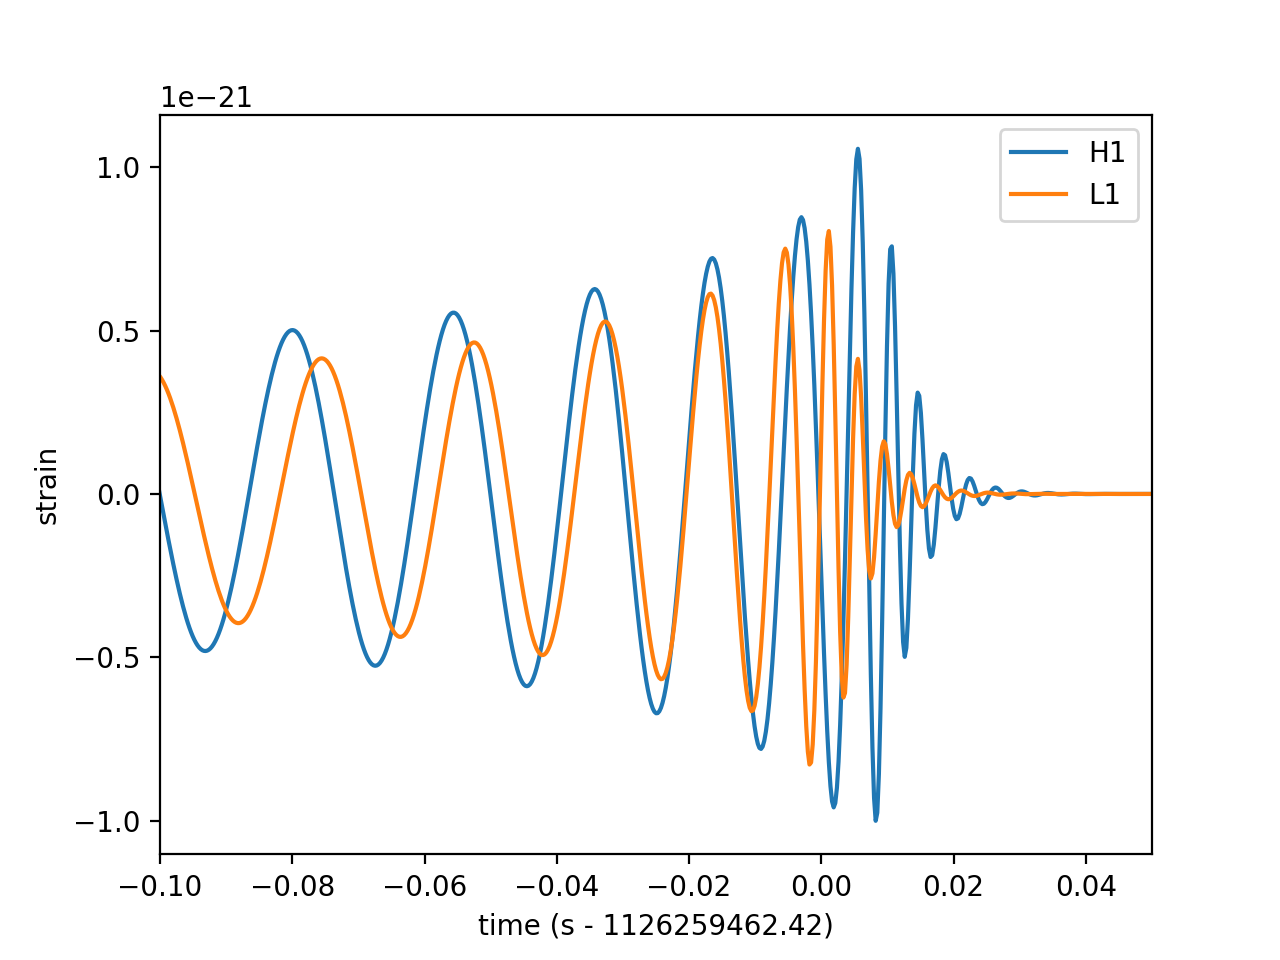

In [29]:
fig, ax = pyplot.subplots()
for (ifo, h) in sorted(waveforms_from_file.items()):
    h = h.time_slice(tstart, tend)
    ax.plot(h.sample_times - tc, h, label=ifo)
ax.legend()
ax.set_xlim(tstart-tc, tend-tc)    
ax.set_xlabel('time (s - {})'.format(tc))
ax.set_ylabel('strain')
fig.show()

### Whitened residuals, data, and maximum likelihood waveform

We whiten the residuals, data, and waveforms so they are visible on the same plot.

In [30]:
whitened_residuals = {}
whitened_waveforms = {}
whitened_data = {}
for ifo in residuals_from_file:
    # calculate the inverse ASD
    psd = psds[ifo]
    invasd = 1./psd**0.5
    kmin = int(filter_fmin/invasd.delta_f)
    invasd[:kmin] *= 0.
    # whiten the residuals
    r = residuals_from_file[ifo].to_frequencyseries() * invasd
    whitened_residuals[ifo] = r.to_timeseries()
    # whiten the waveforms
    htilde = waveforms_from_file[ifo].to_frequencyseries() * invasd
    whitened_waveforms[ifo] = htilde.to_timeseries()
    # whiten the data
    dtilde = data[ifo].to_frequencyseries() * invasd
    whitened_data[ifo] = dtilde.to_timeseries()

<IPython.core.display.Javascript object>


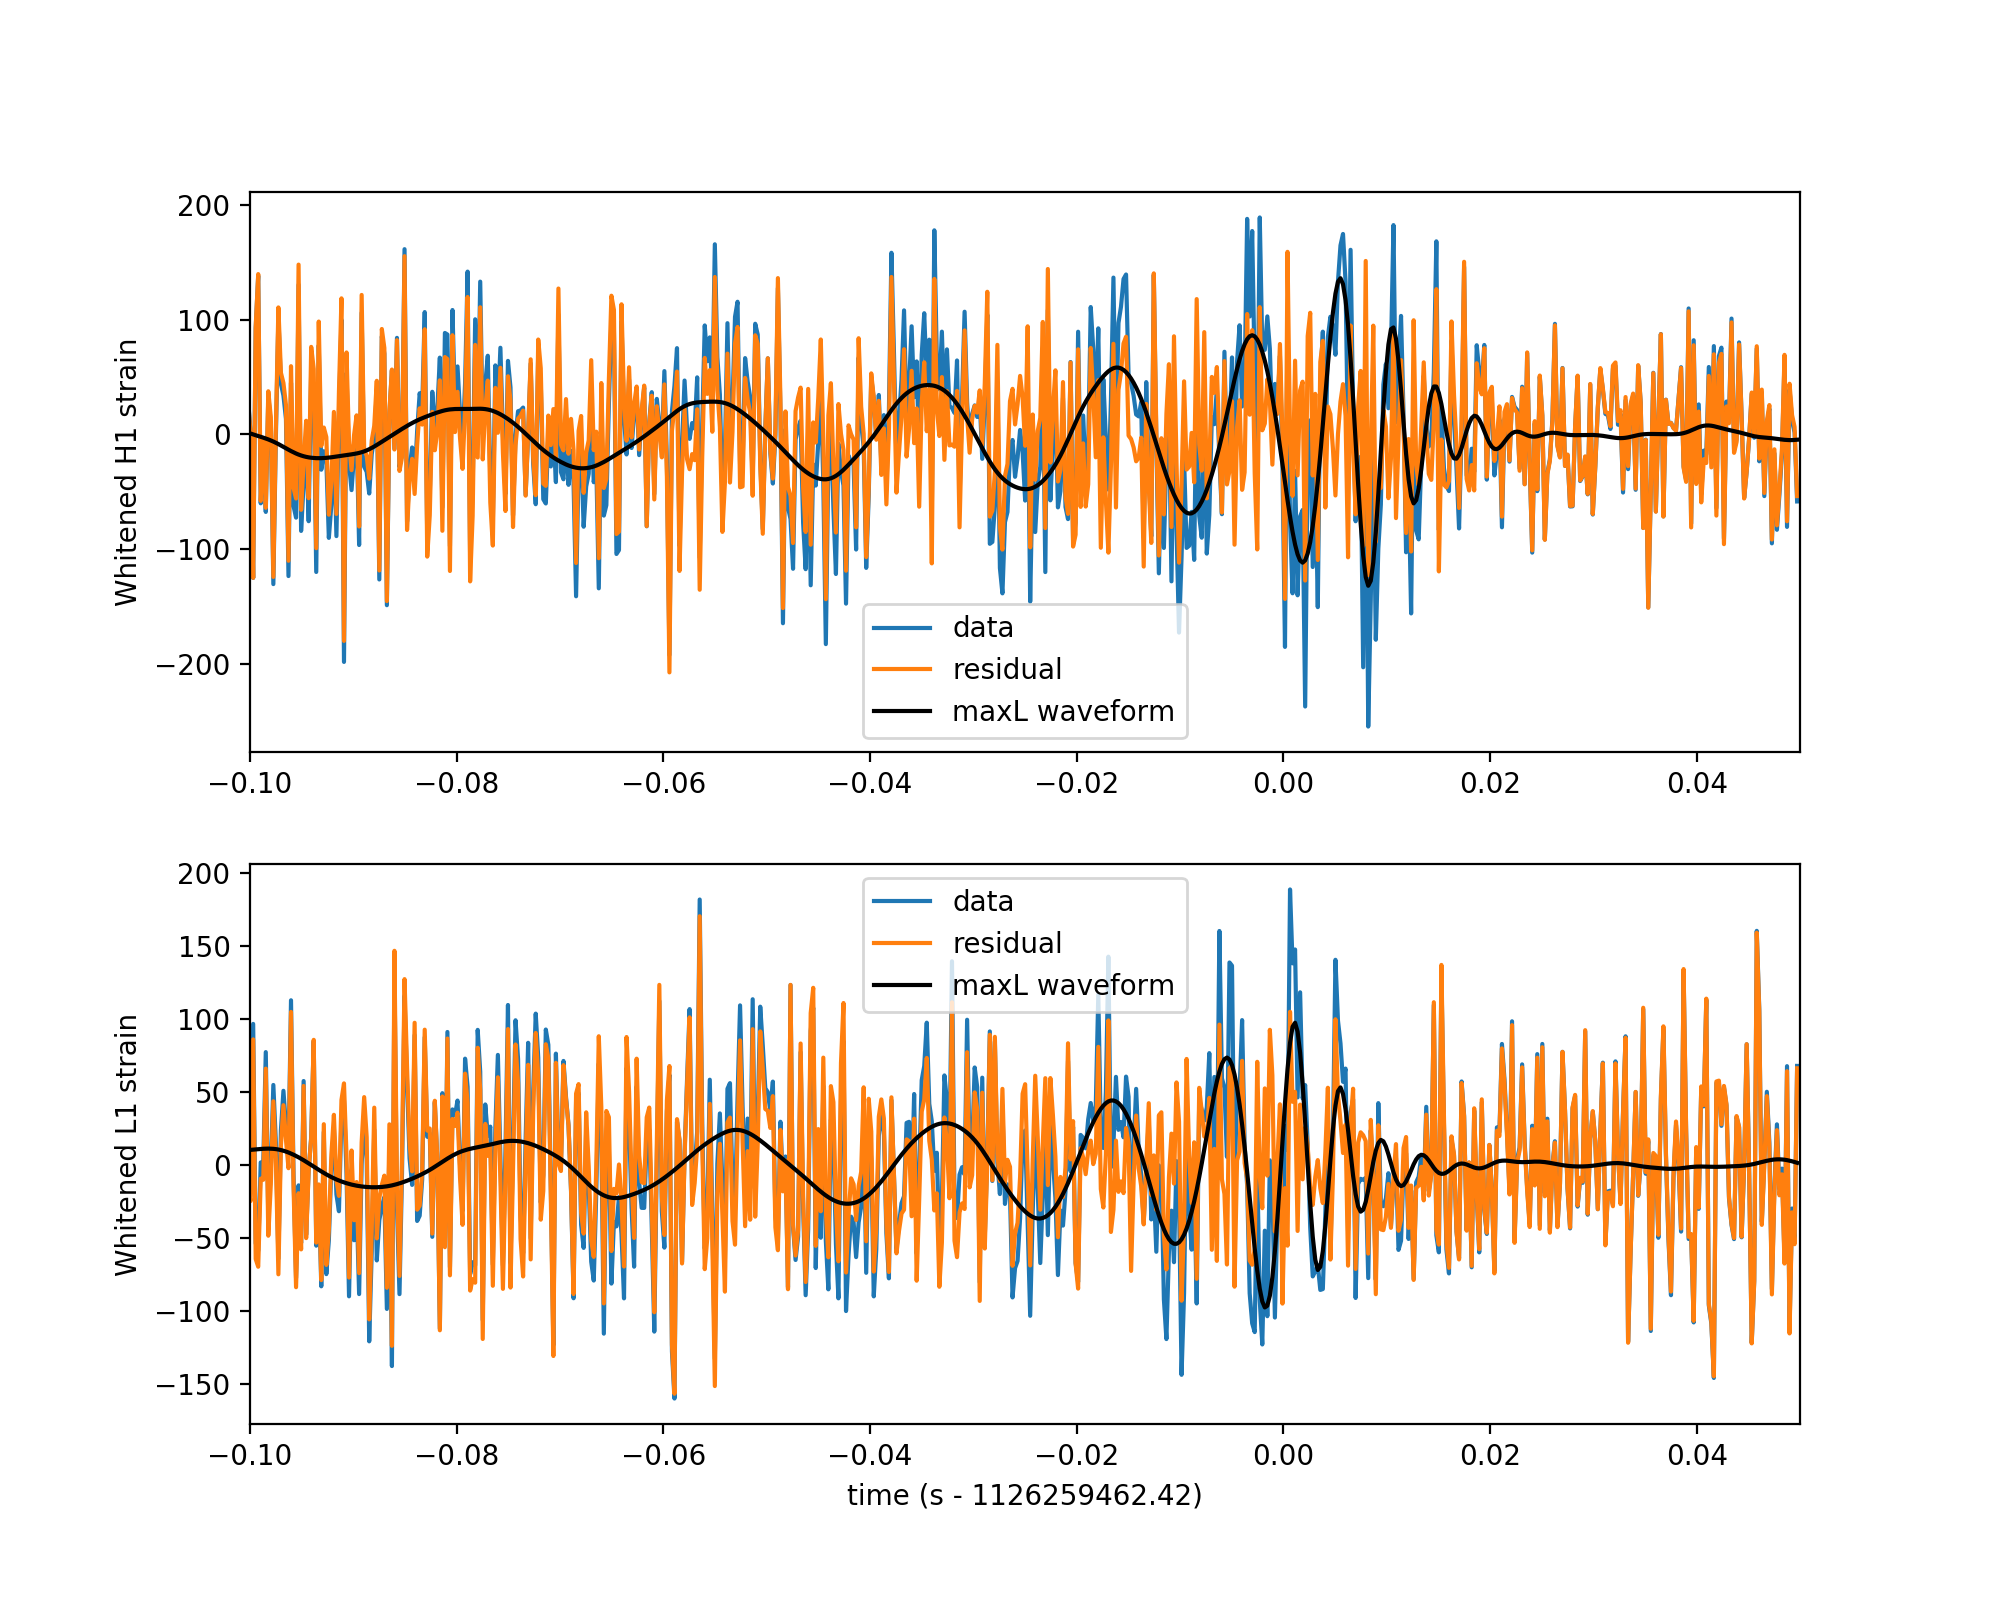

In [31]:
fig, axes = pyplot.subplots(nrows=2,  figsize=(10,8))
for ifo,ax in zip(sorted(whitened_residuals.keys()), axes):
    dslice = whitened_data[ifo].time_slice(tstart, tend)
    rslice = whitened_residuals[ifo].time_slice(tstart, tend)
    hslice = whitened_waveforms[ifo].time_slice(tstart, tend)
    ax.plot(dslice.sample_times-tc, dslice, label='data')
    ax.plot(rslice.sample_times-tc, rslice, label='residual')
    ax.plot(hslice.sample_times-tc, hslice, c='k', label='maxL waveform')
    ax.set_ylabel('Whitened {} strain'.format(ifo))
    ax.legend()
    ax.set_xlim(tstart-tc, tend-tc)
axes[-1].set_xlabel('time (s - {})'.format(tc))
fig.show()